# Initial Closed Form Design

My goal is to create a V-tail to print for the Stratosurfer. First thing should be to take a look at the Stratosurfer's wing dimensions in order to start outlining the requirements for the tail section.

I will start out by trying to find some measurements of the Stratosurfer. What I can't measure, I will assume. A good place to start is [Mark Qvale's website](http://www.itsqv.com/QVM/index.php?title=Strix_StratoSurfer), where he graciously provides some dimensions. I'll list them here in code and have them saved to a file for future use.

In [1]:
itsqv_config = {
    "b_m": 1.500, # Wingspan, meters
    "S_m": 0.0274, # Wing area, meters squared
    "length_m": 1.000, # Fuse length, meters
    "wieght_kg": 1.800, # Assumed weight
    "cg_wing_m": 0.0675, # Center of gravity from wing root
}

import os
import yaml

os.makedirs("data", exist_ok=True)
with open("data/itsqv-dimensions.yaml", "w") as fid:
    yaml.dump(itsqv_config, fid)

Here we have the dimensions of the wing, but we don't have information about the lift-slope curve $\partial C_L / \partial \alpha_w$, which we need in order to design the tail. I measured the cross section of the wing by wrapping the wing with paper-mache, letting it dry, and tracing the interior. I used my [airfoil plotter](https://github.com/MattMarti/airfoil-plotter) to plot out the diagram and approximate it with a NACA airfoil. I found that it looked approximately like a **NACA 4410** airfoil. Unfortunately, the [NACA airfoil database](http://airfoiltools.com/search/index?m%5Bgrp%5D=naca4d&m%5Bsort%5D=1&MAirfoilSearchForm%5BtextSearch%5D=5408&MAirfoilSearchForm%5BmaxThickness%5D=&MAirfoilSearchForm%5BminThickness%5D=&MAirfoilSearchForm%5BmaxCamber%5D=&MAirfoilSearchForm%5BminCamber%5D=&MAirfoilSearchForm%5Bgrp%5D=naca4d&MAirfoilSearchForm%5Bsort%5D=1&yt0=Search) doesn't have this airfoil. However, I can use [xfoil](https://web.mit.edu/drela/Public/web/xfoil/) to try to get information about the coefficient of lift.

### Measurements

There are some additional things to measure. I want to know where the leading edge of the wing is, relative to the nose. Also, I need to know the angle of attack of the wings relative to the airplane body. Since I'm working with a model, I can't change the fuselage, so I want to know where the leading edge of the tail will be too.

My measurements of the fuselage are:
- Front to leading edge of wing: $28.0$ cm
- Length of wing chord: $21.8$ cm
- Length from back of wing to tip of rudder thing: $35.7$ cm
- Tip of rudder thing to end: $10.5$ cm
- Angle of attack of wing: ?

### Airfoil Measurement

In order to do the stability analysis, I need to know the coefficients of lift, drag, and moment of the wing. I can calculate these using XFOIL, but that's going to require that I know the actual cross section of the airfoil. Unfortunately, I have no idea how long replacement Stratosurfer wings will be in stock, so I don't want to cut mine in half or do anything destructive. I decided to wrap paper mache around the wing, and then slide it off after it dries.

In order to do this paper mache thing, I used the following ingredients:
- one cup of glue
- one cup of water
- one cup of flour

I cut one inch wide strips out of a brown paper bag that was leftover from takeout lunch and let them soak in the paper mache mixture. I taped plastic wrap around the wing so that the foam wouldn't get wet, and then wrapped the strips around it, about an inch from the base of the wing. Once it dried, the paper mache slid off surprisingly well!

![alt text](images/paper-mache-airfoil-1.jpg "Paper mache airfoil!")

![alt text](images/paper-mache-airfoil-2.jpg "Not bad!")

Once I had the paper mache, I could (very gently) trace it on paper.

![alt text](images/paper-mache-airfoil-trace.jpg "Not bad!")

Unfortunately, no matter how carful I was, I could not keep from bending the lower portion of the airfoil. This means I can't input these measurements directly into xfoil, and I have to approximate it with a NACA airfoil instead. I wrote an airfoil plotter tool just to load these data in and compare different NACA airfoils. Below is the result:

![alt text](images/airfoil-plotter-4410.PNG "Looks like a NACA 4410!")

It seems like a NACA 4410 fits this pretty well! Pardon the lack of a legend; the blue line is the paper mache trace, while the orange is the NACA airfoil. I added a scaling factor to increase the size of the airfoil a little, since the airfoil doesn't come to a perfect point at the end. Basically, the scale factor is a way to account for a virtual overshoot.

In hindsight, it might have been easier to use a photo editing software to measure the pixels and try to estimate the orientation of the chord line.

## XFOIL Wing Analysis

I will use [XFOIL](https://web.mit.edu/drela/Public/web/xfoil/) to try to get the coefficient of lift and drag (as a function of angle of attack) from the airfoil of the main wing. These parameters will be important to have to design the tail section.


I'll document my inputs to the program here for future reference:

1. `NACA 4410` - Set the airfoil to the 4-digit **4410** since that's about what the airfoil looks like
1. `PPAR` - Open the options menu
1. `N 250` - Set the number of panel nodes to 250. Seems pretty high, and the array limit in my version of XFOIL is 494, so I can't use 500. I'll check out whether decreasing the number of points causes it to converge to different results and report on it anecdotally.
1. `<enter>` - Hit enter to exit `PPAR` menu.
1. `<enter>` - Hit enter again to actually exit `PPAR` menu.
1. `oper` - Open the "Direct Operating Points" menu.
1. `visc 1` - Toggle viscous mode on
1. `mach  0.0669` - Set Mach Number. See below for details on how I got this number.
1. `re 308639` - Set Reynold's Number. See below for details on how I got this number.
1. `iter 200` - Set iteration from 10 to 200.
1. `alfa <r>` - Test a couple of negative angle of attacks to find when they actually converge. I found it at -5
1. `pacc` - Designate that you want data points to be saved.
1. `4410-polar.dat` - Specify file name for `pacc` command.
1. `4410-polar.dump` - Specify file name for `pacc` command.
1. `<enter>` - To escape `pacc` menu. The `.OPERva` is now displayed on the command line.
1. `aseq -7 20 0.5` - Enter the angle of attack sequence at 1/2 degree increments.


From testing different "alfa" values, it seems that XFOIL won't converge for angle of attack below -7 degrees, and the stall angle of attack is about 18 degrees.

### Mach Number

I need to make some assumptions about where I'll be flying. I live at an altitude of about 650 m, but I plan to travel to fly. I'll do my analysis for 1000 m above sea level, but I'd like to return to study the flight envelope at maybe 3000 m in case I decide to go somewhere cool in Colorado. Legally, I can't fly above 400 ft, but I live in a mountainous area so it'd be good to have a little flexibility after the analysis.



For speed, let's assume 50 mph, or about 22.5 m/s. It's a rough conversion, but hey, it's an assumption anyway. Eventually I need to take a look at what the stall speed is, and the max speed. Here's the stats:

- $v_\infty$ = 22.5 [m/s]
- $h_{alt}$ = 1000 [m/s]


Looking up in the standard atmosphere table \[Anderson J., Introduction to Flight, eighth edition, 2016\], I find that the freestream temperature, pressure, and density are:


- $T_\infty$ = 281.66 [K]
- $p_\infty$ = 8.9876e4 [N/m^2]
- $\rho_\infty$ = 1.1117 [kg/m^3]


Then the Mach number is:


$ M_\infty = \frac{v_\infty}{\sqrt{\gamma R T_\infty}} $


And it's air, so the ratio of specific heats is $1.4$, and the gas constant is $R = 287.05 [J/(kg K)]$

In [2]:
import numpy as np

gamma = 1.4
R = 287.05
T_inf_K = 281.66
v_inf_ms = 22.5

M_inf = v_inf_ms / np.sqrt(1.4 * R * T_inf_K)
print(f"Mach number: {M_inf:.4f}")

Mach number: 0.0669


### Reyonld's Number

I'm going to have to make a couple of assumptions here as well. I can refer to my measurements of the airfoil from earlier. The equation for Reynold's Number of an airfoil is:


$ Re = \frac{\rho_\infty v_\infty c}{\mu} $


We can [look up the dynamic viscocity](https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.htm#:~:text=The%20viscosity%20of%20air%20depends,10%2D5%20Pa%C2%B7s%20.) of air and find $\mu = 1.778e-5$ (at $10^\circ C$). We already have the density and freestream velocity. The chord length $c$ was measured when I made the paper mache wrap, and on the Stratosurfer is 215 mm. However, the airfoil plotter tool shows that 215 mm is about 98% of the total airfoil length because the ends don't meet in the back.

In [3]:
rho_inf_si = 1.1117 # Whatever the SI units are
mu = 1.778e-5

c_m = 0.215 / 0.98

Re = rho_inf_si * v_inf_ms * c_m / mu
print(f"Reynold's Number: {Re:.0f}")

Reynold's Number: 308639


### XFOIL Analysis

I was able to use XFOIL to generate coefficient of lift and coefficient of drag for the airfoil at various angle of attack.

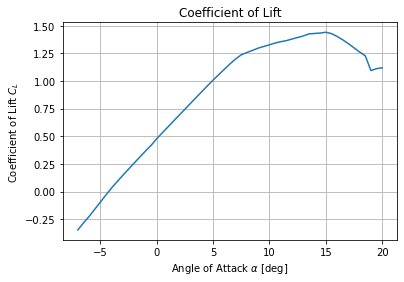

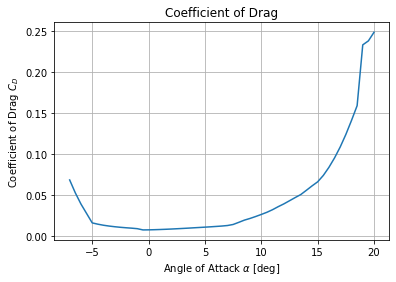

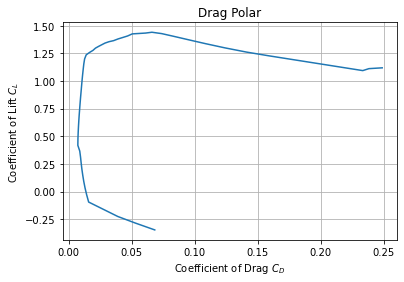

In [4]:
import matplotlib.pyplot as plt

from stratosurfer_tail_design.xfoil_data_parsing import load_xfoil_polar_file

polar_data = load_xfoil_polar_file("data/wing-airfoil-measurements/4410-polar.dat")

plt.figure()
plt.plot(polar_data["alpha"], polar_data["CL"], label="xfoil")
plt.title("Coefficient of Lift")
plt.xlabel(r"Angle of Attack $\alpha$ [deg]")
plt.ylabel(r"Coefficient of Lift $C_L$")
plt.grid()

plt.figure()
plt.plot(polar_data["alpha"], polar_data["CD"], label="xfoil")
plt.title("Coefficient of Drag")
plt.xlabel(r"Angle of Attack $\alpha$ [deg]")
plt.ylabel(r"Coefficient of Drag $C_D$")
plt.grid()

plt.figure()
plt.plot(polar_data["CD"], polar_data["CL"], label="xfoil")
plt.title("Drag Polar")
plt.xlabel(r"Coefficient of Drag $C_D$")
plt.ylabel(r"Coefficient of Lift $C_L$")
plt.grid()

We can try to parameterize the lift-slope curve for some miscellanious calculations.

In [10]:
import numpy as np

def get_lift_slope_curve_params(alpha, cl):
    indeces = np.where(np.logical_and(-5 <= alpha, alpha <= 7.5))
    fit = np.polyfit(alpha[indeces], cl[indeces], deg=1)
    return fit[0], fit[1]

cl_a, cl_0 = get_lift_slope_curve_params(np.asarray(polar_data["alpha"]), np.asarray(polar_data["CL"]))
print(f"CL_a: {cl_a:.3f} per degree")
print(f"CL_0: {cl_0:.3f}")

CL_a: 0.107 per degree
CL_0: 0.468


How does this compare to Thin Airfoil Theory, where the lift slope curve is expected to be $2\pi$?

In [9]:
print(f"CL_a: {cl_a * 180/np.pi:.3f} per radian")
error = ((cl_a * 180/np.pi) - 2*np.pi)/(2*np.pi)
print(f"Percent error: {100*error:.2f} %")

CL_a: 6.128 per radian
Percent error: -2.46 %


That's a lot closer than I thought it would be! However, I still needed XFOIL in order to compute the lift at zero angle of attack. Finally, let's compare all three methods of analysis on a plot.

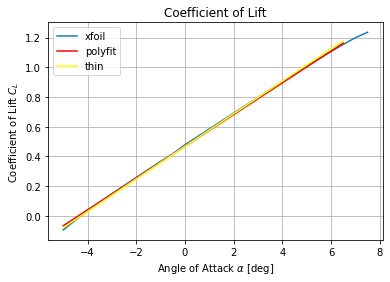

In [13]:
plt.figure()
alpha = np.asarray(polar_data["alpha"])
cl = np.asarray(polar_data["CL"])
indeces = np.where(np.logical_and(-5 <= alpha, alpha <= 7.5))
plt.plot(alpha[indeces], cl[indeces], label="xfoil")
alpha_polyfit = np.linspace(-5, 6.5, 25)
plt.plot(alpha_polyfit, cl_a*alpha_polyfit + cl_0, color="red", label="polyfit")
plt.plot(alpha_polyfit, 2*np.pi * np.pi/180 *alpha_polyfit + cl_0, color="yellow", label="thin")
plt.title("Coefficient of Lift")
plt.xlabel(r"Angle of Attack $\alpha$ [deg]")
plt.ylabel(r"Coefficient of Lift $C_L$")
plt.grid()
plt.legend()